In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image




In [4]:

# 1. Architecture (LazyCNN)
class LazyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=9, stride=2, padding=4)
        self.conv2 = nn.Conv2d(6, 8, kernel_size=7, stride=2, padding=3)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        self.r1 = F.relu(self.conv1(x))
        self.r2 = F.relu(self.conv2(self.r1))
        self.r3 = F.relu(self.conv3(self.r2))
        return self.fc(torch.flatten(self.r3, 1))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LazyCNN().to(device).eval()
model.load_state_dict(torch.load("/kaggle/input/task1/pytorch/default/1/task1final_colored_mnist_cnn.pth", map_location=device))


<All keys matched successfully>

Conv1 weight shape: torch.Size([6, 3, 9, 9])


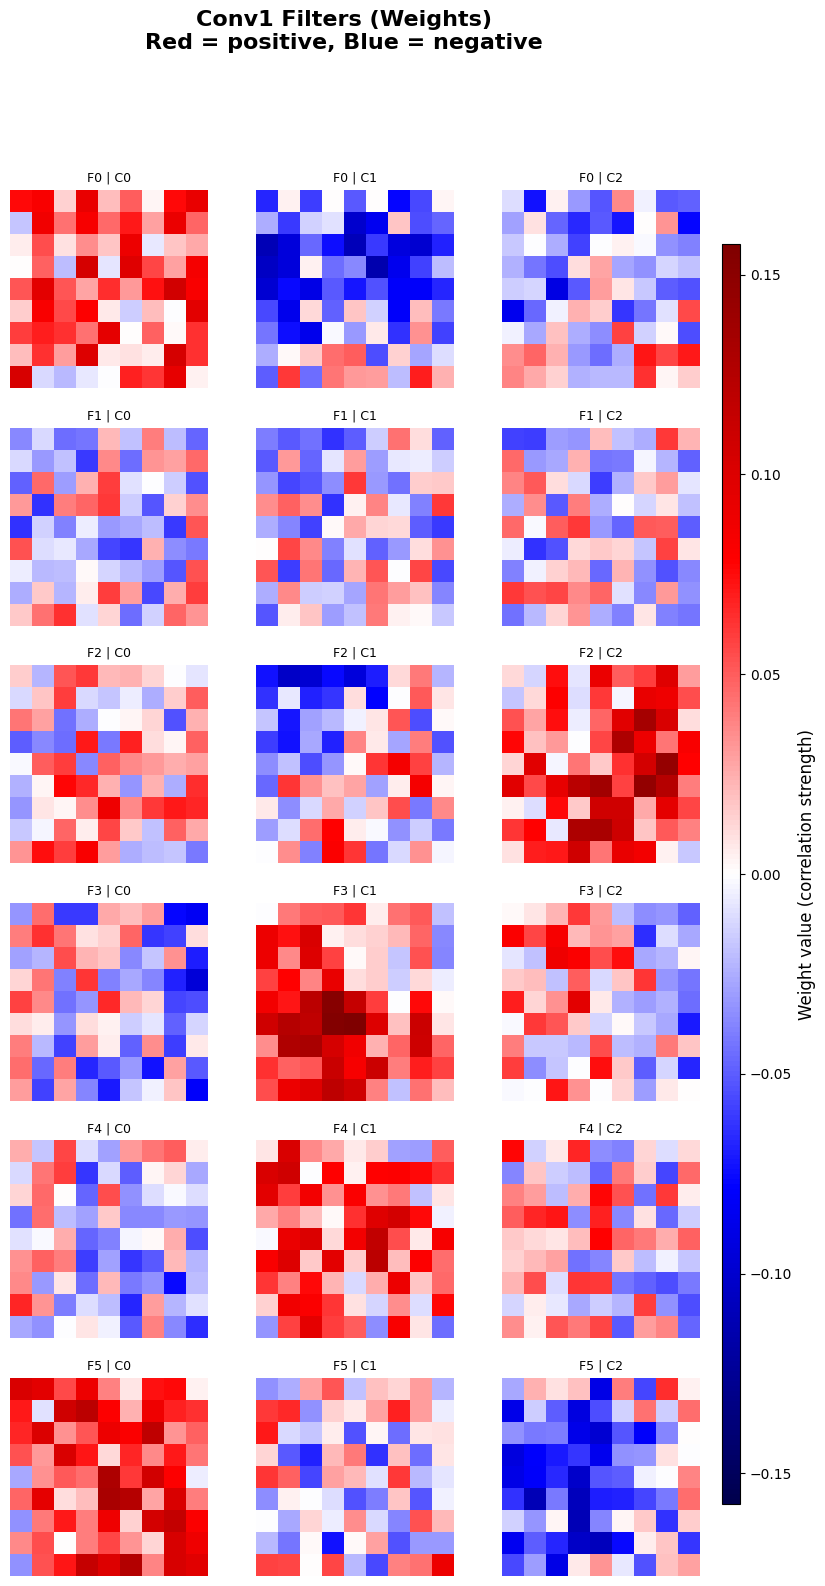

In [5]:
#Filter weights → what the neuron wants
import numpy as np

model.eval()

# ---- Extract Conv1 weights ----
W = model.conv1.weight.data.cpu()
out_channels, in_channels, kH, kW = W.shape
print("Conv1 weight shape:", W.shape)

# ---- Global symmetric range (IMPORTANT) ----
w_abs_max = W.abs().max().item()
vmin, vmax = -w_abs_max, w_abs_max

# ---- Plot filters ----
fig, axes = plt.subplots(
    out_channels,
    in_channels,
    figsize=(in_channels * 3, out_channels * 3)
)

for o in range(out_channels):
    for c in range(in_channels):
        im = axes[o, c].imshow(
            W[o, c],
            cmap="seismic",
            vmin=vmin,
            vmax=vmax
        )
        axes[o, c].axis("off")
        axes[o, c].set_title(f"F{o} | C{c}", fontsize=9)

# ---- MANUAL colorbar axis (THIS IS THE KEY) ----
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Weight value (correlation strength)", fontsize=12)

plt.suptitle(
    "Conv1 Filters (Weights)\nRed = positive, Blue = negative",
    fontsize=16,
    fontweight="bold"
)

plt.subplots_adjust(right=0.9)
plt.show()


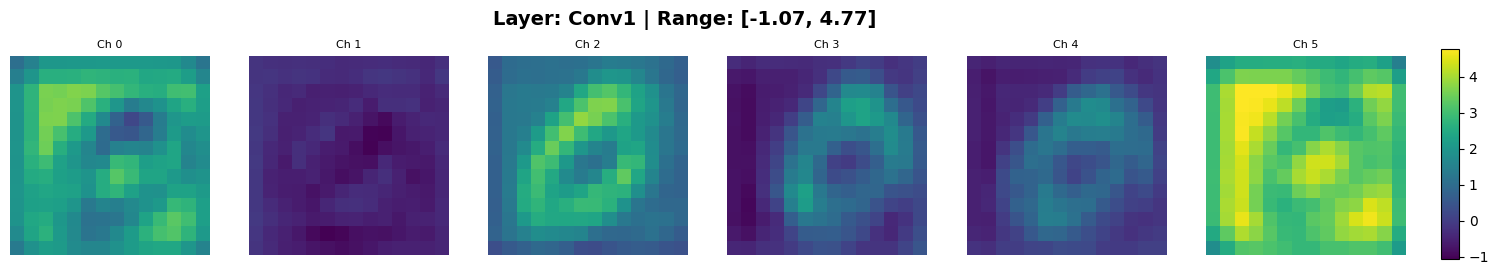

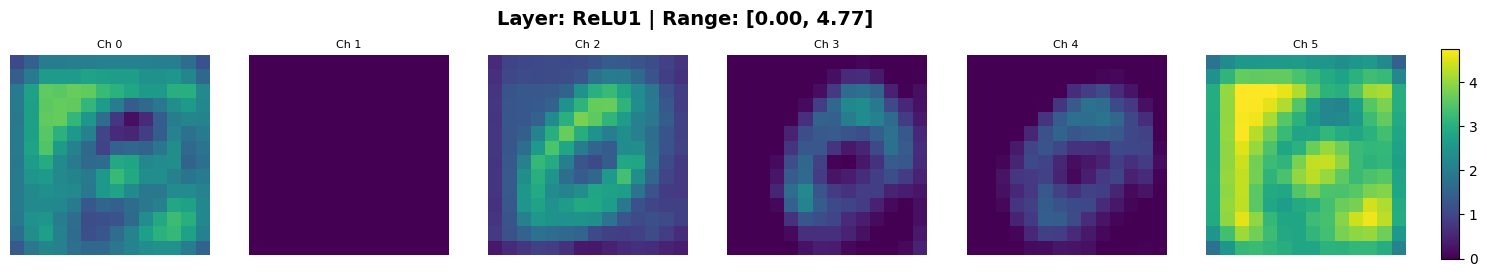

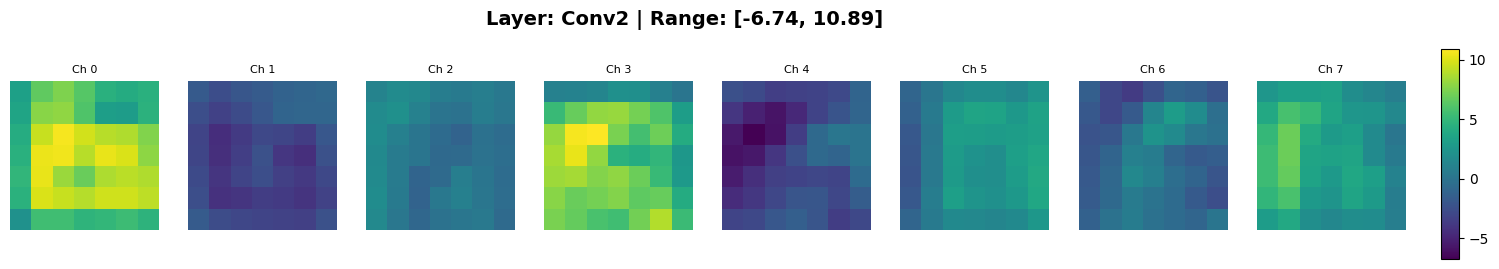

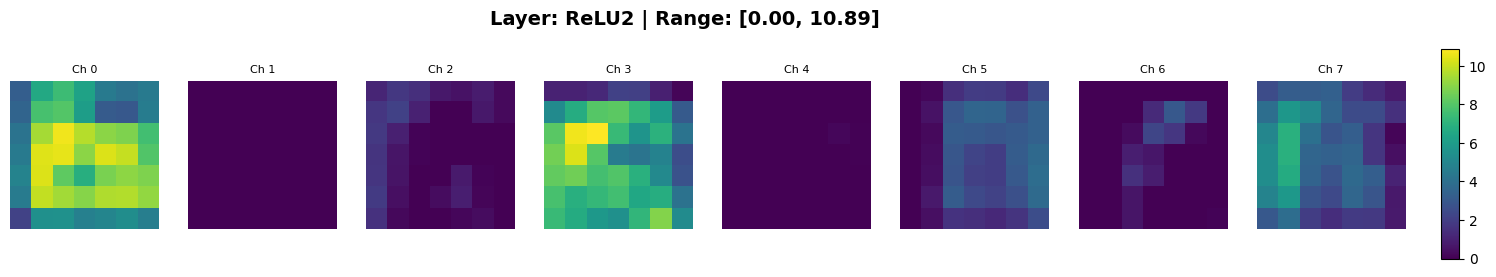

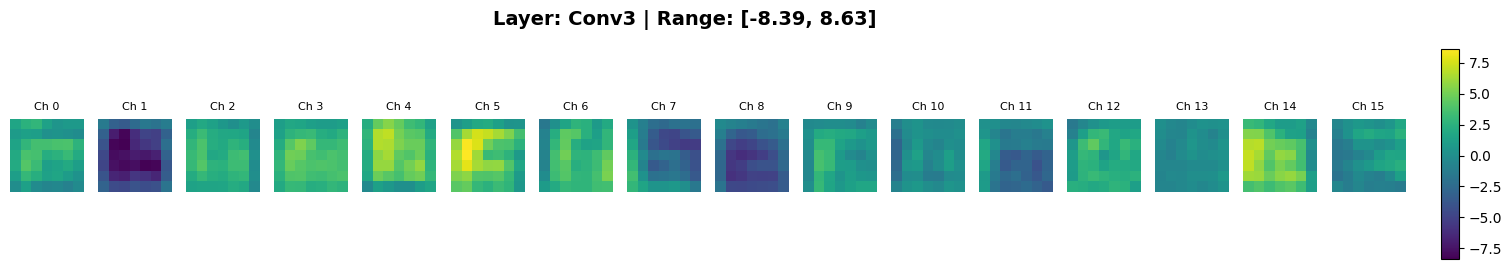

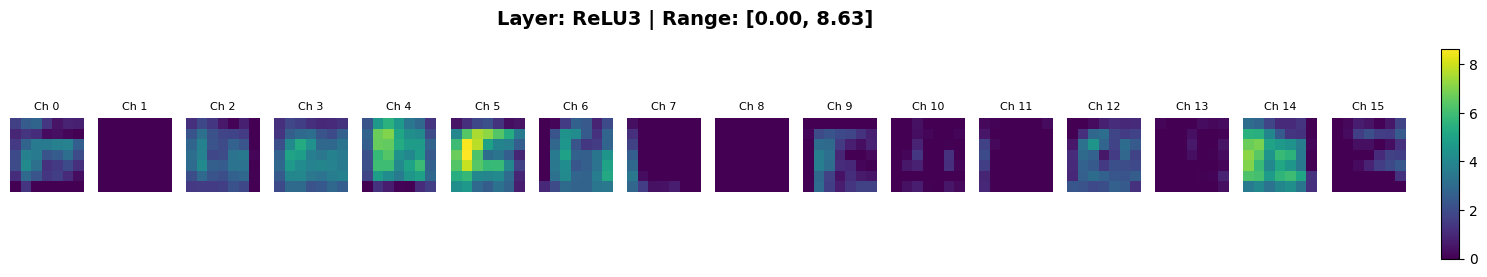

In [4]:


# 2. Visualize Plain Feature Maps layer by layer (Corrected Scaling)
img_path = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/easy_train/0/0_00001.png"
img_t = transforms.ToTensor()(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)

with torch.no_grad():
    model.eval() # Ensure model is in eval mode
    _ = model(img_t)
    
    # Using the stored attributes from your model's forward pass
    sequential_acts = [
        ('Conv1', model.conv1(img_t)), 
        ('ReLU1', model.r1),
        ('Conv2', model.conv2(model.r1)), 
        ('ReLU2', model.r2),
        ('Conv3', model.conv3(model.r2)), 
        ('ReLU3', model.r3)
    ]

for name, act in sequential_acts:
    # Move to CPU and remove batch dim
    output = act.squeeze(0).cpu()
    n = output.shape[0]
    
    # Calculate GLOBAL min and max for this specific layer
    # This prevents the 'black box' issue by ensuring consistent scaling
    layer_min = output.min().item()
    layer_max = output.max().item()
    
    # If the layer is entirely flat (e.g., all zeros), avoid division by zero in plotting
    if layer_min == layer_max:
        layer_max += 1e-5

    fig, axes = plt.subplots(1, n, figsize=(18, 3))
    
    # Handle case where there might only be 1 channel (so axes isn't an array)
    if n == 1:
        axes = [axes]

    for i in range(n):
        # Force every channel to use the layer-wide min/max
        im = axes[i].imshow(output[i], cmap='viridis', vmin=layer_min, vmax=layer_max)
        axes[i].axis('off')
        axes[i].set_title(f"Ch {i}", fontsize=8)
    
    # Add a unified colorbar for the row
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.suptitle(f"Layer: {name} | Range: [{layer_min:.2f}, {layer_max:.2f}]", 
                 fontsize=14, fontweight='bold')
    plt.show()

In [6]:
def invert_embedding(image_path, layer_name, iterations=400, lr=0.08):
    ref_img = Image.open(image_path).convert('RGB')
    ref_t = transforms.ToTensor()(ref_img).unsqueeze(0).to(device)
    
    activations = {}
    def hook_fn(m, i, o): activations['val'] = o
    
    # Map for all possible embedding points
    layer_map = {
        "conv1": model.conv1, "relu1": model.conv1, # relu1 is output of conv1 in our forward
        "conv2": model.conv2, "relu2": model.conv2,
        "conv3": model.conv3, "relu3": model.conv3
    }
    
    handle = layer_map[layer_name].register_forward_hook(hook_fn)
    
    # Step A: Get reference Phi(X_ref)
    with torch.no_grad():
        model(ref_t)
        # Note: If targeting ReLU, we apply F.relu to the hooked conv output
        phi_ref = F.relu(activations['val'].clone()) if "relu" in layer_name else activations['val'].clone()
    
    # Step B: Start with "Blank" Random Image X
    torch.manual_seed(42) # For reproducibility
    x = torch.randn(1, 3, 28, 28, device=device, requires_grad=True)
    
    # Store initial noise for display
    initial_noise = torch.clamp(x.detach().cpu().squeeze().permute(1,2,0), 0, 1).numpy()

    optimizer = torch.optim.Adam([x], lr=lr)
    
    # Step C: Optimization Loop
    for _ in range(iterations):
        optimizer.zero_grad()
        model(x)
        phi_x = F.relu(activations['val']) if "relu" in layer_name else activations['val']
        loss = F.mse_loss(phi_x, phi_ref)
        loss.backward(retain_graph=True)
        optimizer.step()
        x.data.clamp_(0, 1) # Keep pixels valid
        
    handle.remove()
    final_img = x.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    return initial_noise, final_img


In [7]:

# Execute and Plot
layers_to_invert = ["conv1", "relu1", "conv2", "relu2", "conv3", "relu3"]
ref_path = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/easy_train/1/1_00003.png"



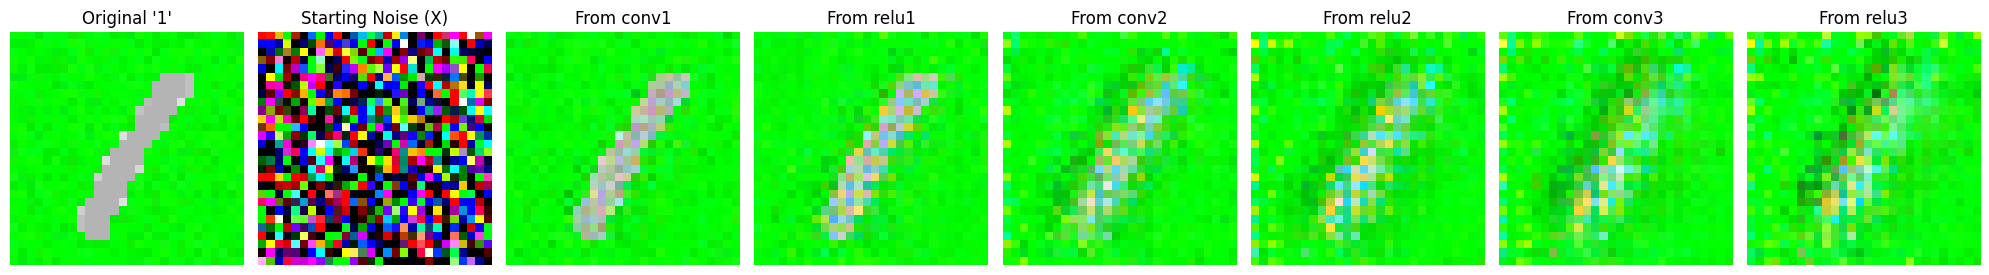

In [8]:
# Get the initial noise and reconstructions
noise, _ = invert_embedding(ref_path, "conv1", iterations=1) # Just to get the noise frame

plt.figure(figsize=(20, 5))

# Plot 1: Original
plt.subplot(1, len(layers_to_invert) + 2, 1)
plt.imshow(Image.open(ref_path))
plt.title("Original '1'")
plt.axis('off')

# Plot 2: Starting Noise
plt.subplot(1, len(layers_to_invert) + 2, 2)
plt.imshow(noise)
plt.title("Starting Noise (X)")
plt.axis('off')

# Plot 3-N: Reconstructions
for i, layer_name in enumerate(layers_to_invert):
    _, recon = invert_embedding(ref_path, layer_name)
    plt.subplot(1, len(layers_to_invert) + 2, i + 3)
    plt.imshow(recon)
    plt.title(f"From {layer_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

--- Step 1: Respective Original Image ---


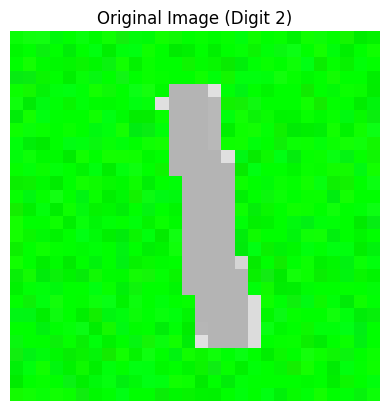

--- Step 2: Precomputing 50 iterations ---


100%|██████████| 50/50 [00:00<00:00, 157.17it/s]


interactive(children=(IntSlider(value=0, description='Iteration:', max=50), Output()), _dom_classes=('widget-i…

<function __main__.show_dream(step)>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import ipywidgets as widgets
from IPython.display import display

# 1. Architecture 
class LazyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=9, stride=2, padding=4)
        self.conv2 = nn.Conv2d(6, 8, kernel_size=7, stride=2, padding=3)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        return self.fc(x)

# 2. Setup and Load
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LazyCNN().to(device).eval()
MODEL_PATH = "/kaggle/input/task1/pytorch/default/1/task1final_colored_mnist_cnn.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# 3. Load Sample & Show Original Immediately
img_path = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/easy_train/1/1_00006.png"
image = Image.open(img_path).convert('RGB')

print("--- Step 1: Respective Original Image ---")
plt.imshow(image)
plt.title("Original Image (Digit 2)")
plt.axis('off')
plt.show()

# 4. Preparation for Optimization
img_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
img_tensor.requires_grad = True

iterations = 50
lr = 0.05
target_class = 1
history = [] 

# --- KEY FIX: Capture Iteration 0 (The start state) ---
initial_frame = img_tensor.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
history.append(np.clip(initial_frame, 0, 1))

print(f"--- Step 2: Precomputing {iterations} iterations ---")
for i in tqdm(range(1, iterations + 1)):
    model.zero_grad()
    output = model(img_tensor)
    loss = output[0, target_class]
    loss.backward()
    
    with torch.no_grad():
        grad = img_tensor.grad
        grad /= (torch.mean(torch.abs(grad)) + 1e-7)
        img_tensor += lr * grad
        img_tensor.grad.zero_()
        
        # Save frame
        frame = img_tensor.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        history.append(np.clip(frame, 0, 1))

# 5. Interactive UI

def show_dream(step):
    plt.figure(figsize=(6, 6))
    plt.imshow(history[step])
    plt.title(f"Iteration: {step} | Probing: Target Class {target_class}")
    plt.axis('off')
    plt.show()

slider = widgets.IntSlider(value=0, min=0, max=iterations, step=1, description='Iteration:')
widgets.interact(show_dream, step=slider)

In [37]:
torch.manual_seed(42)
INITIAL_NOISE = torch.randn(1, 3, 28, 28, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8325317..3.445625].


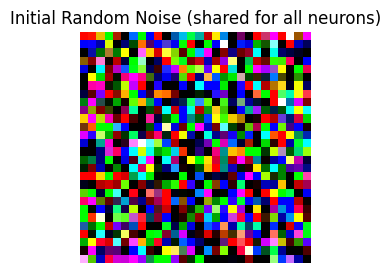

In [38]:
plt.figure(figsize=(3,3))
plt.imshow(INITIAL_NOISE.squeeze().permute(1,2,0).cpu().numpy())
plt.title("Initial Random Noise (shared for all neurons)")
plt.axis("off")
plt.show()


In [39]:
def deep_probe(layer_name, channel_idx, init_noise, mode="raw", iterations=200, lr=0.1):

    # Clone so each neuron gets same start, but independent optimization
    input_img = init_noise.clone().detach().requires_grad_(True)

    optimizer = optim.Adam([input_img], lr=lr)

    # Hook
    activations = {}
    def hook_fn(m, i, o):
        activations['val'] = o

    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    for _ in range(iterations):
        optimizer.zero_grad()
        model(input_img)

        A = activations['val'][0, channel_idx]

        if mode == "raw":
            loss = -A.sum()
        elif mode == "channel_mean":
            loss = -A.mean()
        elif mode == "spatial_neuron":
            h, w = A.shape
            loss = -A[h // 2, w // 2]
        else:
            raise ValueError("Unknown mode")

        loss.backward()
        optimizer.step()
        input_img.data.clamp_(0, 1)

    handle.remove()

    return input_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()


In [40]:
def probe_all_neurons(layer_name, init_noise, mode="raw", iterations=200, lr=0.1):

    layer = dict(model.named_modules())[layer_name]
    num_neurons = layer.out_channels

    results = []

    print(f"\nProbing {layer_name} | neurons = {num_neurons} | mode = {mode}")

    for ch in range(num_neurons):
        print(f"  → Neuron {ch}")
        img = deep_probe(
            layer_name=layer_name,
            channel_idx=ch,
            init_noise=init_noise,
            mode=mode,
            iterations=iterations,
            lr=lr
        )
        results.append(img)

    return results


In [43]:
layer_to_probe = "conv1"

imgs_raw = probe_all_neurons(layer_to_probe, INITIAL_NOISE, mode="raw")
imgs_channel = probe_all_neurons(layer_to_probe, INITIAL_NOISE, mode="channel_mean")
imgs_spatial = probe_all_neurons(layer_to_probe, INITIAL_NOISE, mode="spatial_neuron")



Probing conv1 | neurons = 6 | mode = raw
  → Neuron 0
  → Neuron 1
  → Neuron 2
  → Neuron 3
  → Neuron 4
  → Neuron 5

Probing conv1 | neurons = 6 | mode = channel_mean
  → Neuron 0
  → Neuron 1
  → Neuron 2
  → Neuron 3
  → Neuron 4
  → Neuron 5

Probing conv1 | neurons = 6 | mode = spatial_neuron
  → Neuron 0
  → Neuron 1
  → Neuron 2
  → Neuron 3
  → Neuron 4
  → Neuron 5


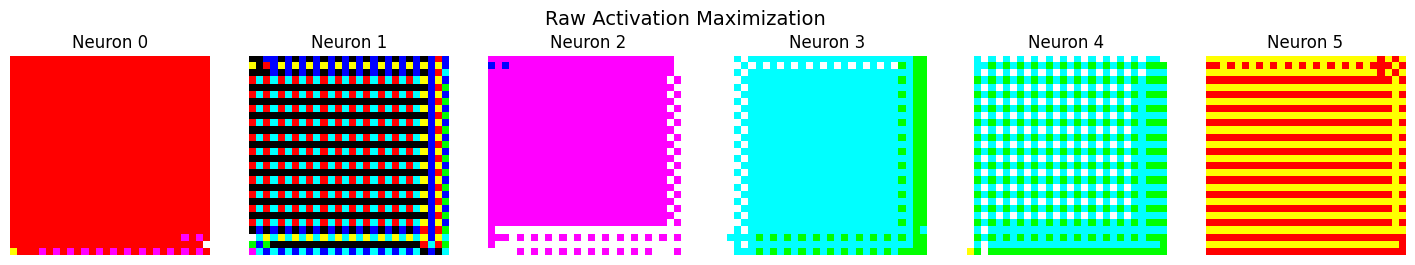

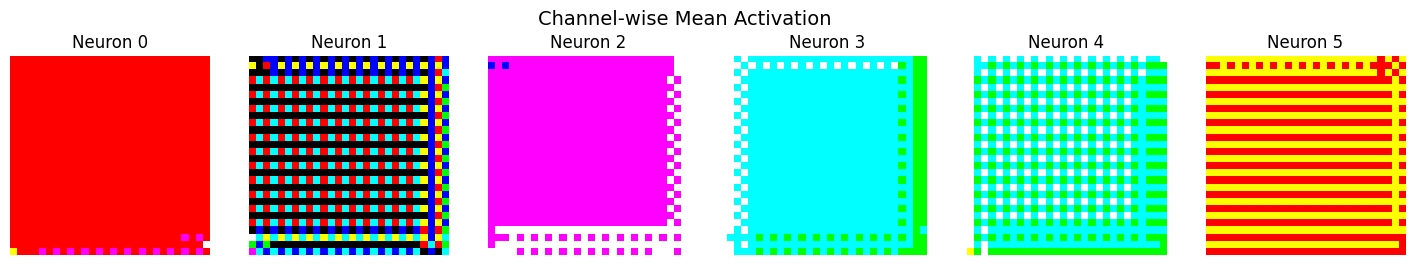

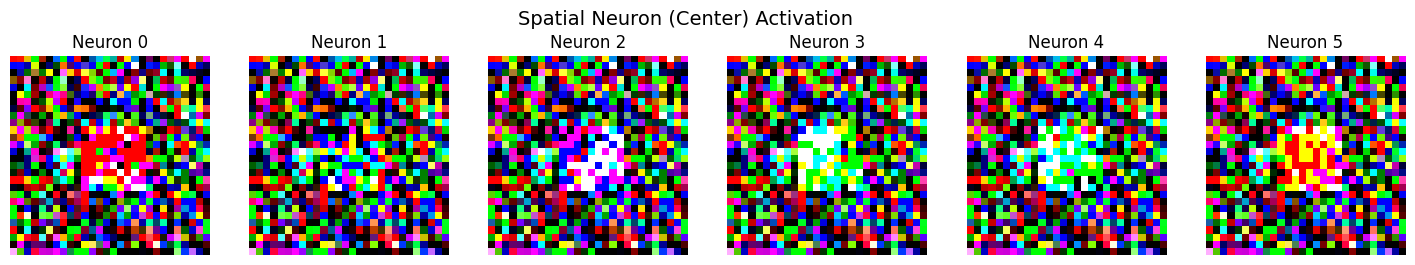

In [44]:
show_grid(imgs_raw, "Raw Activation Maximization")
show_grid(imgs_channel, "Channel-wise Mean Activation")
show_grid(imgs_spatial, "Spatial Neuron (Center) Activation")


In [45]:
layer_to_probe = "conv2"

imgs_raw = probe_all_neurons(layer_to_probe, INITIAL_NOISE, mode="raw")
imgs_channel = probe_all_neurons(layer_to_probe, INITIAL_NOISE, mode="channel_mean")
imgs_spatial = probe_all_neurons(layer_to_probe, INITIAL_NOISE, mode="spatial_neuron")



Probing conv2 | neurons = 8 | mode = raw
  → Neuron 0
  → Neuron 1
  → Neuron 2
  → Neuron 3
  → Neuron 4
  → Neuron 5
  → Neuron 6
  → Neuron 7

Probing conv2 | neurons = 8 | mode = channel_mean
  → Neuron 0
  → Neuron 1
  → Neuron 2
  → Neuron 3
  → Neuron 4
  → Neuron 5
  → Neuron 6
  → Neuron 7

Probing conv2 | neurons = 8 | mode = spatial_neuron
  → Neuron 0
  → Neuron 1
  → Neuron 2
  → Neuron 3
  → Neuron 4
  → Neuron 5
  → Neuron 6
  → Neuron 7


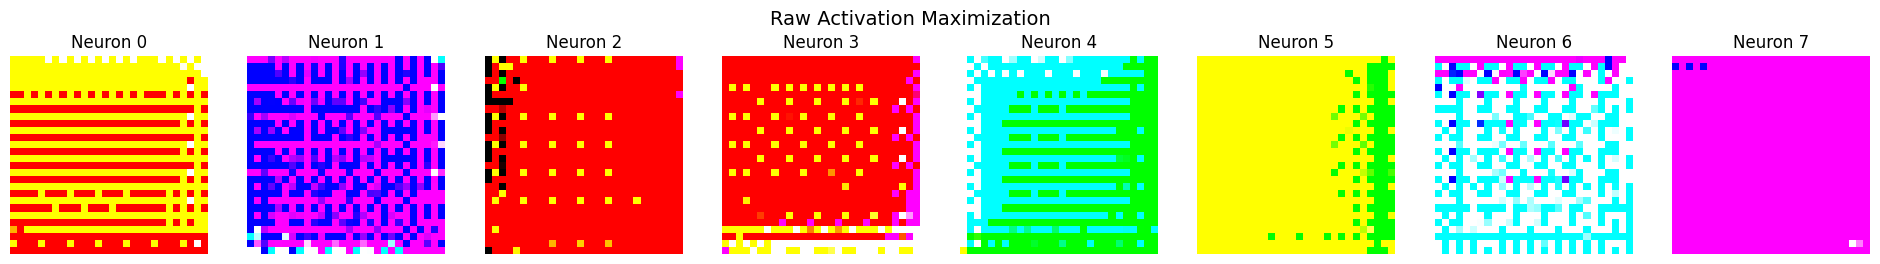

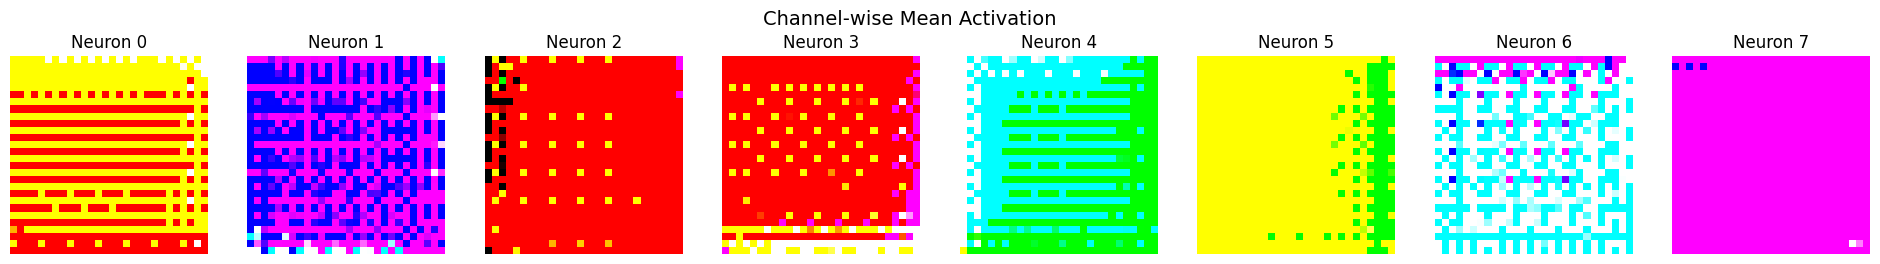

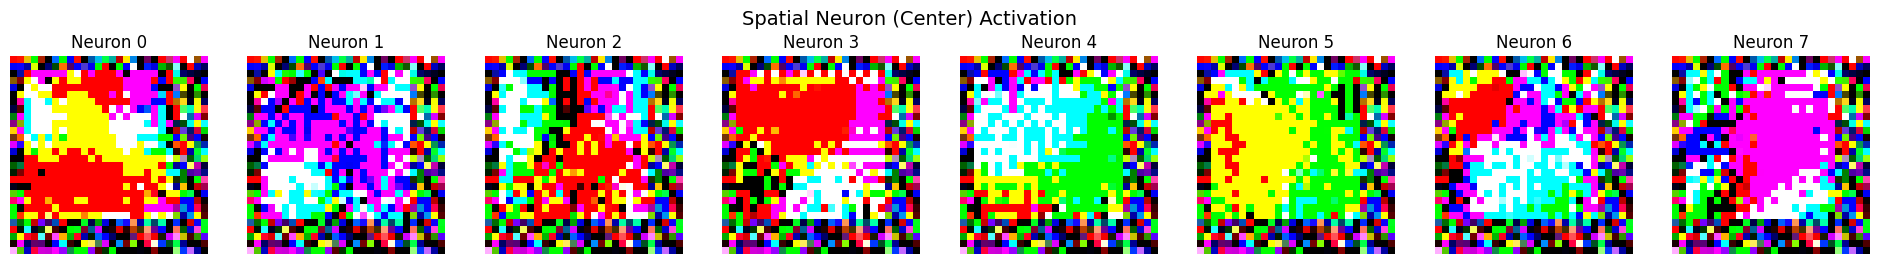

In [46]:
show_grid(imgs_raw, "Raw Activation Maximization")
show_grid(imgs_channel, "Channel-wise Mean Activation")
show_grid(imgs_spatial, "Spatial Neuron (Center) Activation")


In [47]:
layer_to_probe = "conv3"

imgs_raw = probe_all_neurons(layer_to_probe, INITIAL_NOISE, mode="raw")
imgs_channel = probe_all_neurons(layer_to_probe, INITIAL_NOISE, mode="channel_mean")
imgs_spatial = probe_all_neurons(layer_to_probe, INITIAL_NOISE, mode="spatial_neuron")



Probing conv3 | neurons = 16 | mode = raw
  → Neuron 0
  → Neuron 1
  → Neuron 2
  → Neuron 3
  → Neuron 4
  → Neuron 5
  → Neuron 6
  → Neuron 7
  → Neuron 8
  → Neuron 9
  → Neuron 10
  → Neuron 11
  → Neuron 12
  → Neuron 13
  → Neuron 14
  → Neuron 15

Probing conv3 | neurons = 16 | mode = channel_mean
  → Neuron 0
  → Neuron 1
  → Neuron 2
  → Neuron 3
  → Neuron 4
  → Neuron 5
  → Neuron 6
  → Neuron 7
  → Neuron 8
  → Neuron 9
  → Neuron 10
  → Neuron 11
  → Neuron 12
  → Neuron 13
  → Neuron 14
  → Neuron 15

Probing conv3 | neurons = 16 | mode = spatial_neuron
  → Neuron 0
  → Neuron 1
  → Neuron 2
  → Neuron 3
  → Neuron 4
  → Neuron 5
  → Neuron 6
  → Neuron 7
  → Neuron 8
  → Neuron 9
  → Neuron 10
  → Neuron 11
  → Neuron 12
  → Neuron 13
  → Neuron 14
  → Neuron 15


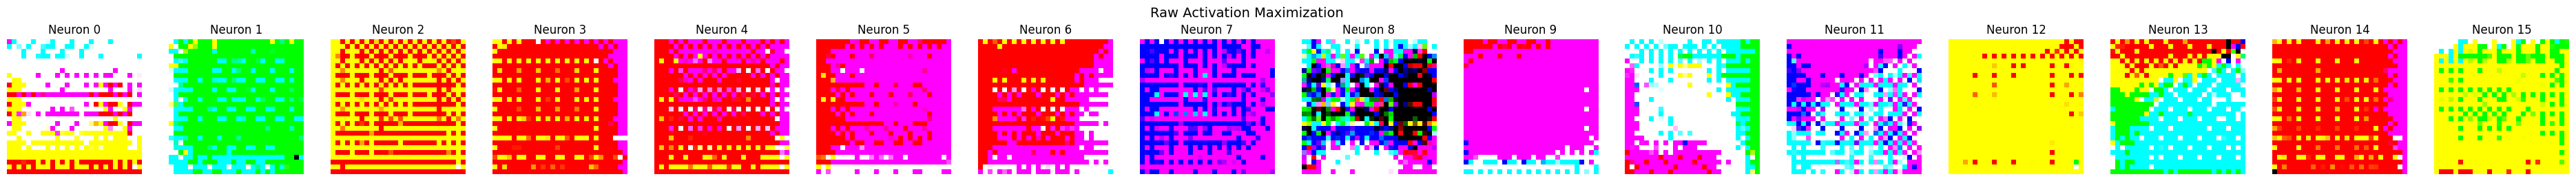

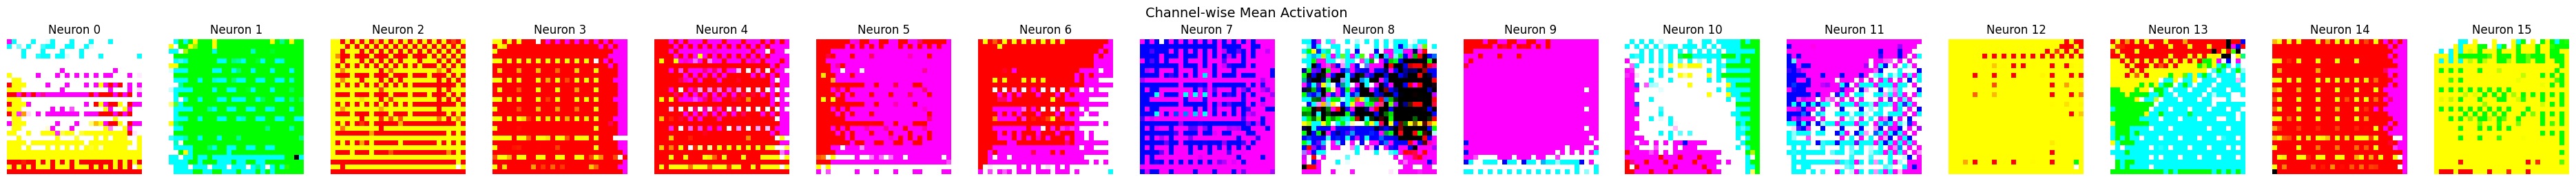

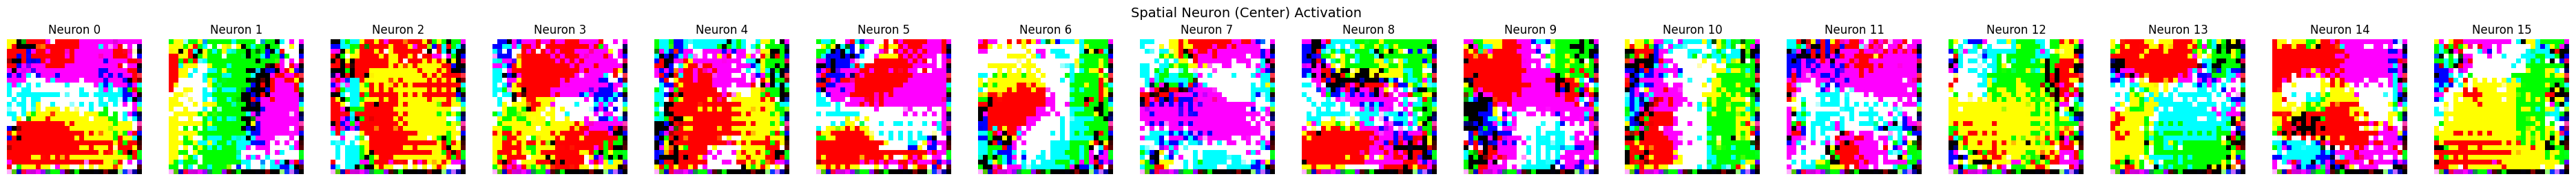

In [49]:
show_grid(imgs_raw, "Raw Activation Maximization")
show_grid(imgs_channel, "Channel-wise Mean Activation")
show_grid(imgs_spatial, "Spatial Neuron (Center) Activation")


In [71]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [73]:
resnet = models.resnet18(weights=None)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

MODEL_PATH = "/kaggle/input/task4/pytorch/default/1/task1_resnet18_colored_mnist.pth"
resnet.load_state_dict(torch.load(MODEL_PATH, map_location=device))

resnet = resnet.to(device).eval()
print("ResNet-18 loaded successfully")


ResNet-18 loaded successfully


In [74]:
resnet_transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [75]:
resnet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

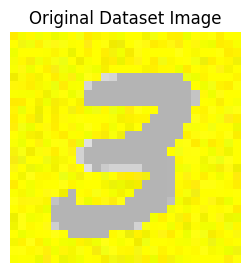

In [77]:
img_path = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/easy_train/3/3_00007.png"

img = Image.open(img_path).convert("RGB")

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.title("Original Dataset Image")
plt.axis("off")
plt.show()

img_t = resnet_transform(img).unsqueeze(0).to(device)


In [78]:
layer = resnet.layer2[0].conv1
print(layer)


Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


In [79]:
activations = {}

def hook_fn(module, input, output):
    activations["val"] = output.detach()

handle = layer.register_forward_hook(hook_fn)

with torch.no_grad():
    preds = resnet(img_t)

handle.remove()

feature_maps = activations["val"].squeeze(0).cpu()  # (C, H, W)
print("Feature maps shape:", feature_maps.shape)


Feature maps shape: torch.Size([128, 28, 28])


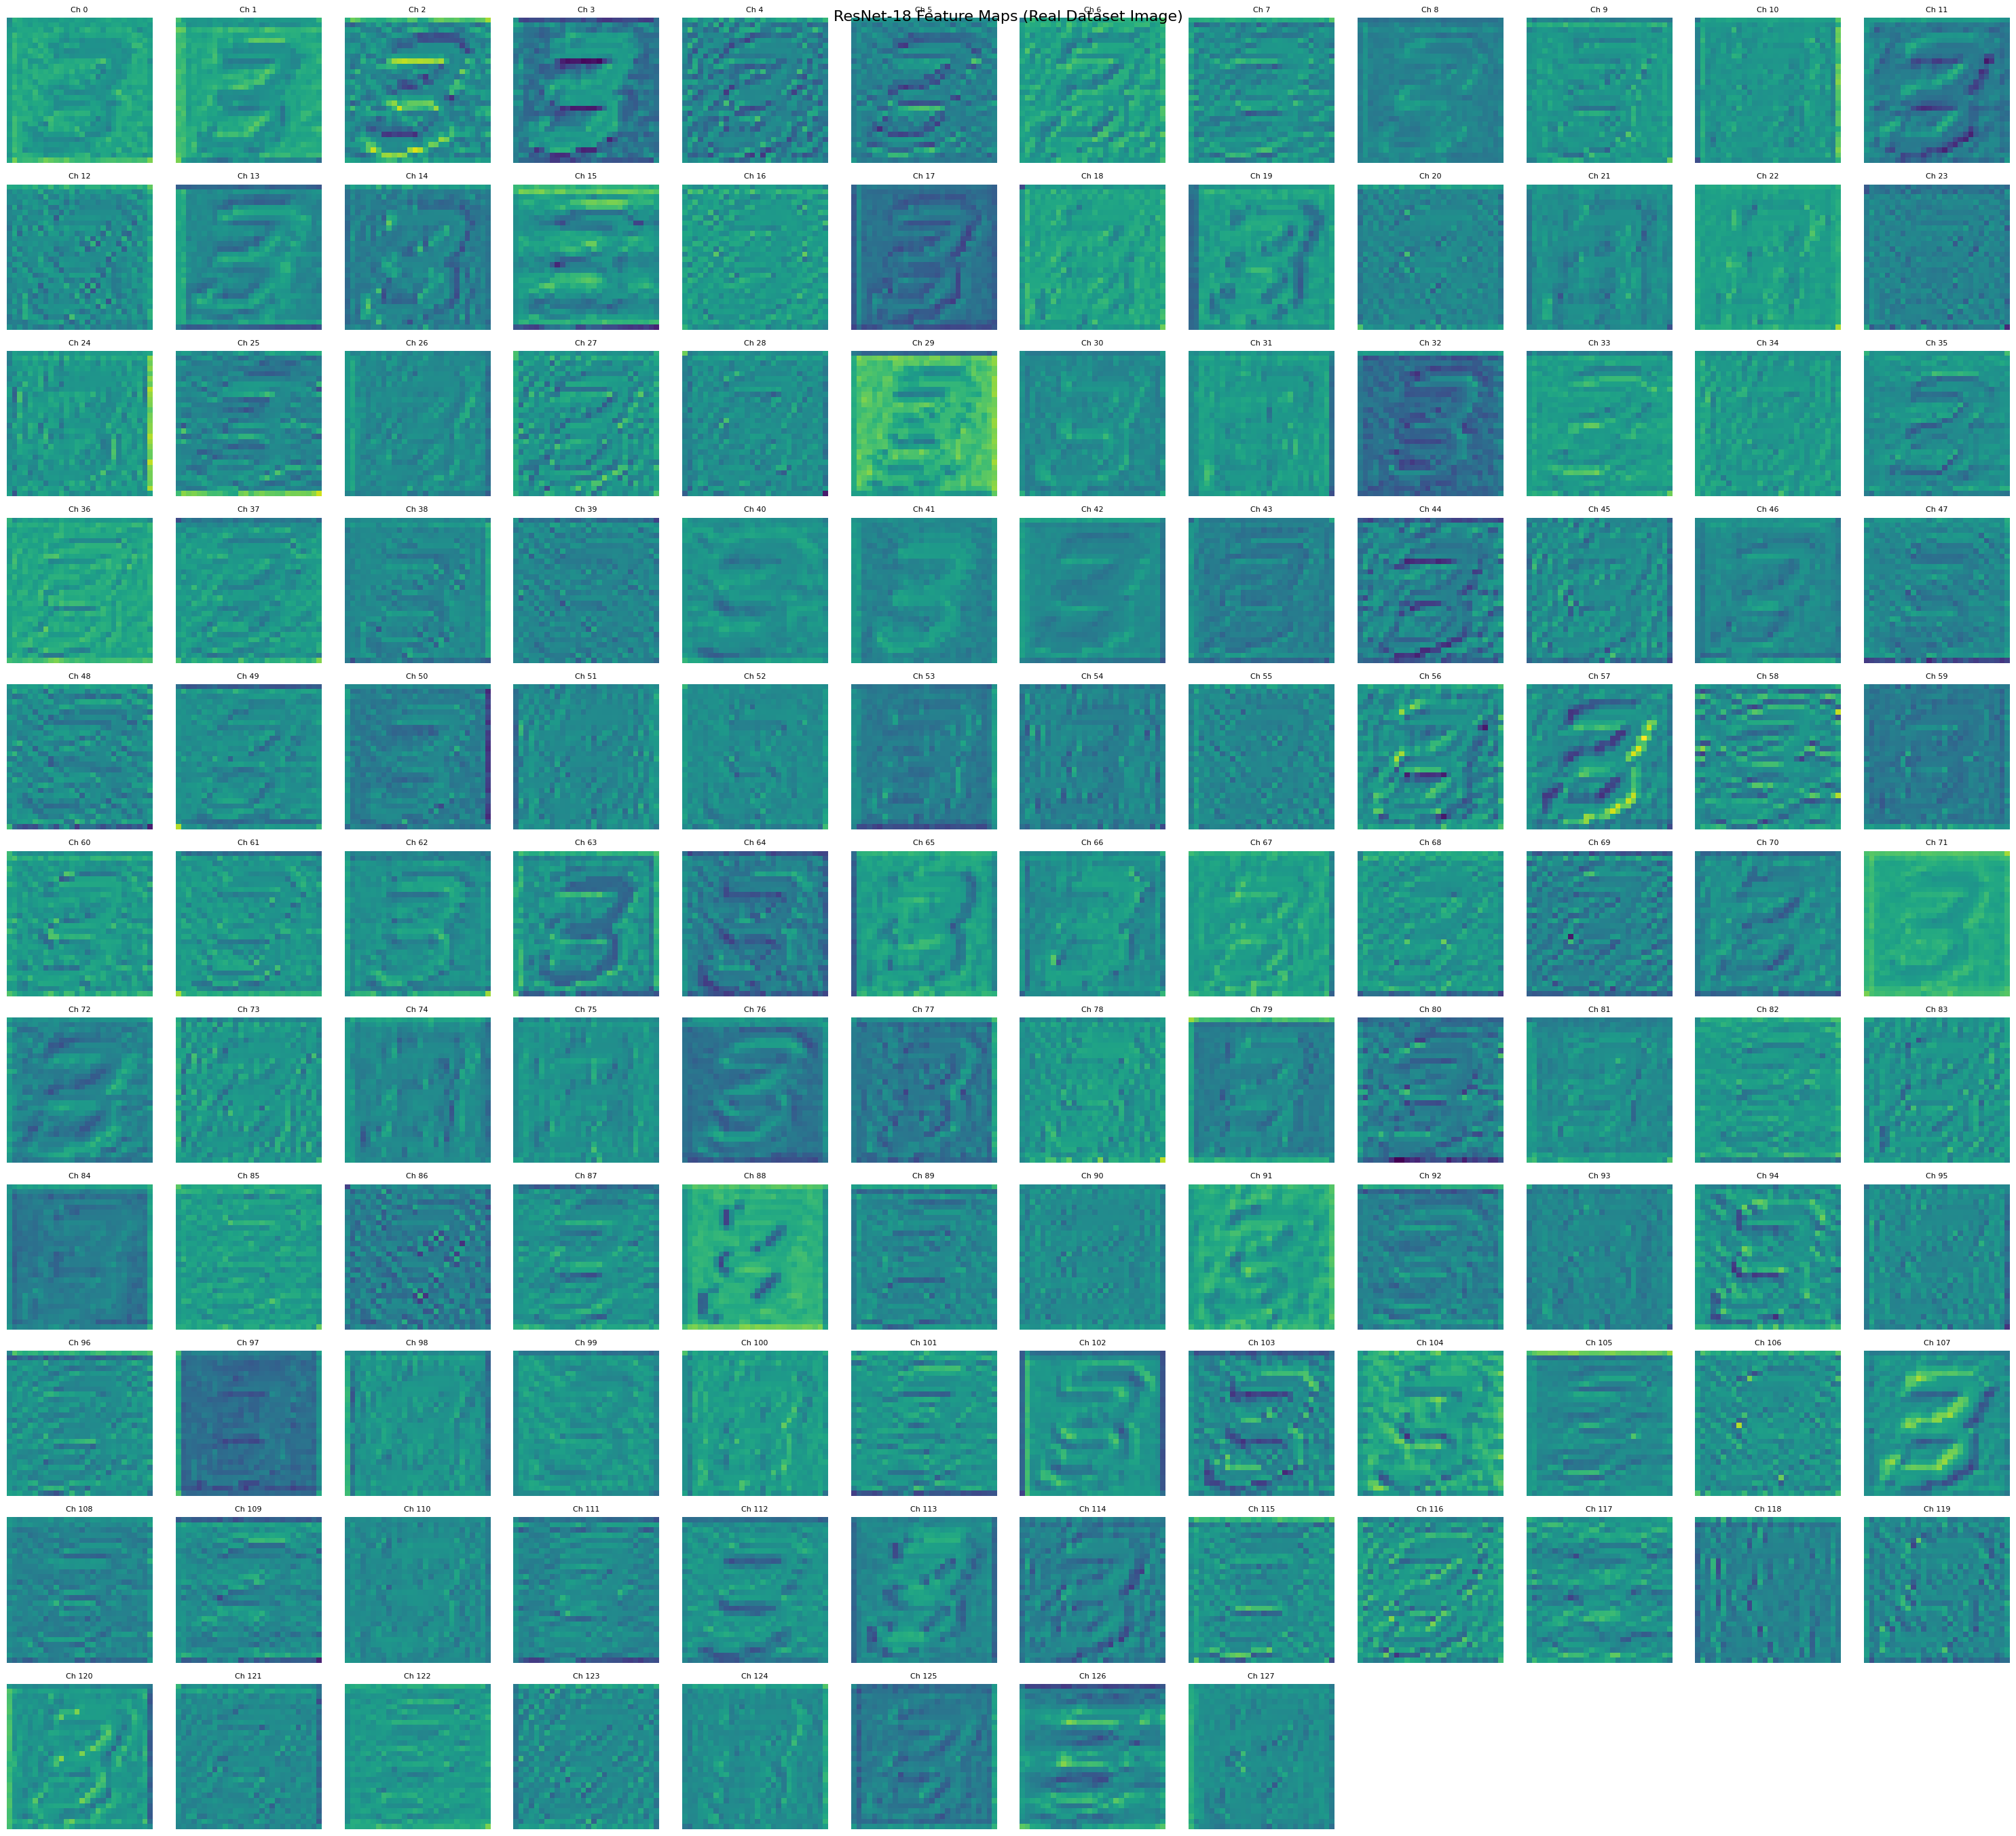

In [80]:
C = feature_maps.shape[0]
rows = int(np.sqrt(C))
cols = int(np.ceil(C / rows))

vmin, vmax = feature_maps.min().item(), feature_maps.max().item()

fig = plt.figure(figsize=(cols * 2.5, rows * 2.5))

for i in range(C):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(feature_maps[i], cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title(f"Ch {i}", fontsize=8)
    ax.axis("off")

plt.suptitle("ResNet-18 Feature Maps (Real Dataset Image)", fontsize=16)
plt.tight_layout()
plt.show()


In [82]:
layer = resnet.layer3[0].conv2
neuron_idx = 5
print(layer)


Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [83]:
activations = {}

def hook_fn(module, input, output):
    activations["val"] = output

handle = layer.register_forward_hook(hook_fn)

torch.manual_seed(42)
input_noise = torch.randn(1, 3, 224, 224, requires_grad=True, device=device)

optimizer = torch.optim.Adam([input_noise], lr=0.1)
steps = 60

resnet.eval()

for _ in range(steps):
    optimizer.zero_grad()
    resnet(input_noise)

    A = activations["val"][0, neuron_idx]
    loss = -A.mean()
    loss.backward()

    optimizer.step()
    input_noise.data.clamp_(0, 1)

handle.remove()


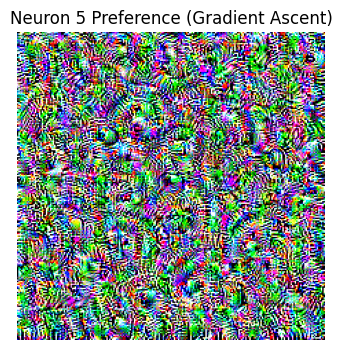

In [84]:
pref_img = input_noise.detach().cpu().squeeze().permute(1, 2, 0)

plt.figure(figsize=(4,4))
plt.imshow(pref_img)
plt.title(f"Neuron {neuron_idx} Preference (Gradient Ascent)")
plt.axis("off")
plt.show()


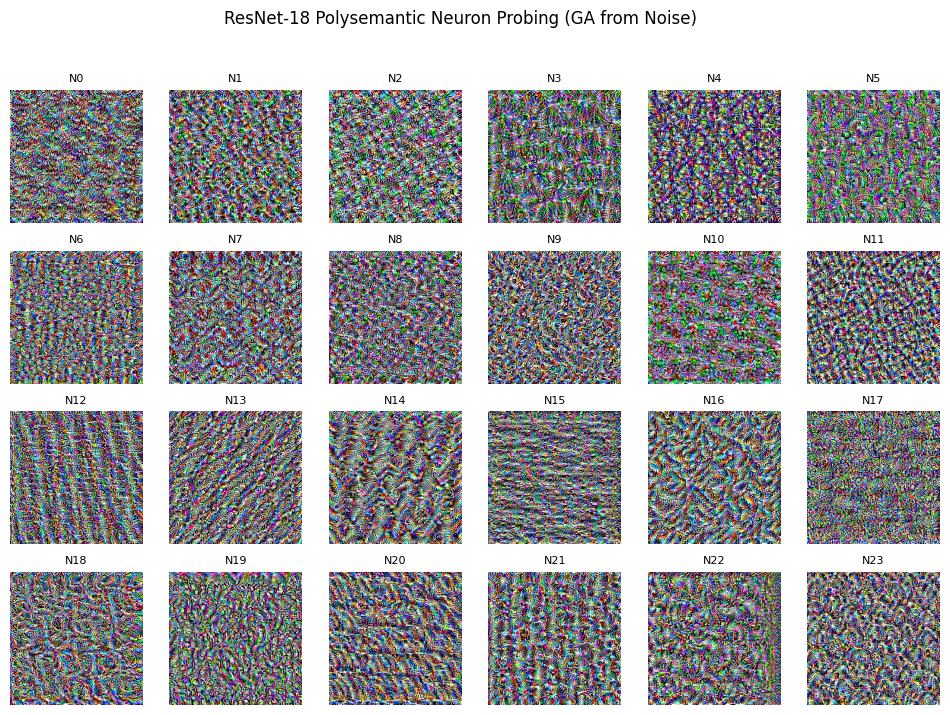

In [85]:
rows, cols = 4, 6
fig = plt.figure(figsize=(12, 8))

for i in range(min(rows * cols, layer.out_channels)):

    torch.manual_seed(42)
    x = torch.randn(1, 3, 224, 224, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([x], lr=0.1)

    def hook_fn(m, inp, out):
        global fmap
        fmap = out

    handle = layer.register_forward_hook(hook_fn)

    for _ in range(40):
        optimizer.zero_grad()
        resnet(x)
        loss = -fmap[0, i].mean()
        loss.backward()
        optimizer.step()
        x.data.clamp_(0, 1)

    handle.remove()

    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(x.detach().cpu().squeeze().permute(1,2,0))
    ax.set_title(f"N{i}", fontsize=8)
    ax.axis("off")

plt.suptitle("ResNet-18 Polysemantic Neuron Probing (GA from Noise)")
plt.show()
